---
# artistic style reconstruction

---

### Import libraries and set up environment

In [58]:
import torch
from torch import nn
import torch.optim as optim

from torchvision.models.vgg import vgg19, VGG19_Weights
from torchvision import transforms

from PIL import Image

constants

In [59]:
IMAGE_PATH = "../data/starry_night.jpg"

RANDOM_SEED = 42
TARGET_LAYERS = [0, 5]
LR = 0.01
NUM_ITERATION = 1000

Set up model

In [60]:
weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()
transform = weights.transforms()

In [61]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Freeze the VGG model parameters

In [62]:
for param in model.parameters():
    param.requires_grad = False

In [63]:
image = Image.open(IMAGE_PATH)

## style reconstruction

In [64]:
image_t = transform(image)
batch = image_t.unsqueeze(0)
_, width, height = image_t.shape
print(f"width: {width}, height: {height}")

width: 224, height: 224


In [65]:
image_t.requires_grad

False

In [66]:
def generate_white_noise_image(
    width,
    height,
):
    white_noise_image = torch.randn(1, 3, width, height)
    white_noise_image = transform(white_noise_image)
    white_noise_image.requires_grad = True
    return white_noise_image

In [67]:
def tensor_to_image(image_t):
    return transforms.Compose([transforms.ToPILImage()])(
        image_t.squeeze(0).cpu().clone().detach()
    )

In [68]:
white_noise_image_t = generate_white_noise_image(width,height)
print(white_noise_image_t.requires_grad)

True


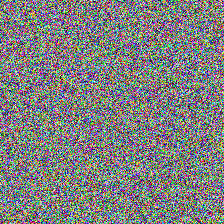

In [69]:
tensor_to_image(white_noise_image_t)

In [70]:
def get_features(model, x):
    """
    forward pass and get the features for some target layer
    """
    features = []
    features = {}
    for i, layer in enumerate(model.features):
        x = layer(x)
        features[i] = x
    return features

Loss function

In [71]:
def gram(features):
    t = features.view(64, width * height)
    gram = torch.mm(t, t.t())
    return gram

In [72]:
def loss_style(white_noise_features, real_image_features, layer):
    white_noise_features_for_layer = white_noise_features[layer]
    gram_wn = gram(white_noise_features_for_layer)

    real_image_features_for_layer = real_image_features[layer]
    gram_real = gram(real_image_features_for_layer)

    loss = nn.MSELoss()(gram_real, gram_wn)
    return loss

Optimization loop

In [73]:
def reconstruct_style(
    generated_image,  # white noise image
    real_image_features,
    layer,
    num_iteration=NUM_ITERATION,
):
    optimizer = optim.Adam([generated_image], lr=LR)
    for i in range(num_iteration):
        optimizer.zero_grad()

        generated_image_features = get_features(model, generated_image)
        # Calculate loss
        loss = loss_style(real_image_features, generated_image_features, layer)

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clip the values to be in the valid range
        with torch.no_grad():
            generated_image.data.clamp_(0, 1)

        print(f"Iteration {i+1}/{num_iteration}, Loss: {loss.item()}")
    new_generated_image = tensor_to_image(generated_image)
    return new_generated_image

In [74]:
real_image_features = get_features(model, image_t)
generated_image = reconstruct_style(white_noise_image_t, real_image_features, layer=0, num_iteration=NUM_ITERATION)

Iteration 1/1000, Loss: 48304189440.0
Iteration 2/1000, Loss: 82598824.0
Iteration 3/1000, Loss: 82907248.0
Iteration 4/1000, Loss: 83149880.0
Iteration 5/1000, Loss: 83349464.0
Iteration 6/1000, Loss: 83517208.0
Iteration 7/1000, Loss: 83659880.0
Iteration 8/1000, Loss: 83781968.0
Iteration 9/1000, Loss: 83886656.0
Iteration 10/1000, Loss: 83976328.0
Iteration 11/1000, Loss: 84052864.0
Iteration 12/1000, Loss: 84117768.0
Iteration 13/1000, Loss: 84172344.0
Iteration 14/1000, Loss: 84217640.0
Iteration 15/1000, Loss: 84254592.0
Iteration 16/1000, Loss: 84283960.0
Iteration 17/1000, Loss: 84306384.0
Iteration 18/1000, Loss: 84322464.0
Iteration 19/1000, Loss: 84332736.0
Iteration 20/1000, Loss: 84337648.0
Iteration 21/1000, Loss: 84337584.0
Iteration 22/1000, Loss: 84332952.0
Iteration 23/1000, Loss: 84324064.0
Iteration 24/1000, Loss: 84311208.0
Iteration 25/1000, Loss: 84294736.0
Iteration 26/1000, Loss: 84274840.0
Iteration 27/1000, Loss: 84251832.0
Iteration 28/1000, Loss: 84225912.

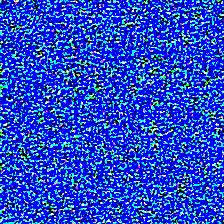

In [75]:
generated_image